# Model comparison for the Sithas catchment, Gulf of Corinth

**John Armitage**

*In this notebook I will make a preliminary comparison of various model explorations of the Sithas catchment within the Gulf of Corinth, and discuss directions which the work should or could take.*

The aim is to explore how two very different models behave when simulating short timescale landscape erosion and deposition. The two models are [HAIL-CAESAR](https://github.com/dvalters/HAIL-CAESAR), which will be shortened to HC, and [fLEM](https://github.com/johnjarmitage/flem).

HC is a `C++` version of the `C#` CAESAR-Lisflood model developed by Tom Coulthard and others ([Coulthard et al., 2013](https://doi.org/10.1002/esp.3478)). The advantage of HC is that it can be run on any machine, Linux, Mac OS, Windows, etc. HC is parallelised using OpenMP. It solves for the overland flow of water using the Lisflood FP algorithm of [Bates et al. (2010)](https://doi.org/10.1016/j.jhydrol.2010.03.027), which is a simplification of the shallow water equations for the flow of water over the surface of a landscape. Sediment is subsequently transported down slope either as a single suspended grain size, or as multiple bedloads of different characteristic grain size. Bedload sediment transport follows the empirical [Wilcox & Crowe (2003)](https://doi.org/10.1061/(ASCE)0733-9429(2003)129:2(120)) model for fractional transport of grains. Susspended loads are a linear function of water flux with a constant setling velocity defined.

fLEM is a much simpler model of the transport of sediment down slope, assuming that water only goes down topographic gradients ([Armitage, 2019](https://doi.org/10.5194/esurf-7-67-2019)). It solves for the resulting diffusion equation using the finite element library `FEniCS` written in `Python`. It is not optimized nor parallelized.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rasterio as rio
import pyvista as pv
from osgeo import gdal
import datetime

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

## Sithas catchment

The Sithas catchment is on the southern shore of the Gulf of Corinth in Greece. It is a small catchment of the order of 25 km long.

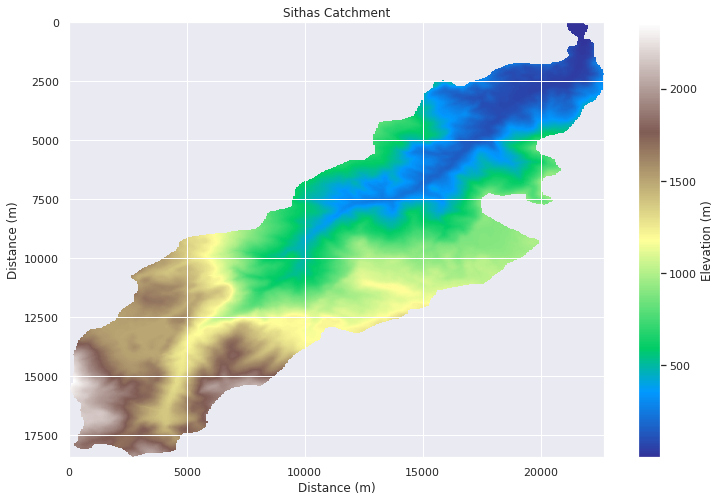

In [2]:
grdfile = '/work/armitagj/runs/caesar-explore/sithas/DEM/removed_pits/DEM_SITHAS_CATCH09-2020_CUT_RESAMPLE_WARP50.tif'
rio_array = rio.open(grdfile)
pix = rio_array.transform[0]
data_array = rio_array.read(1).astype(float) 
data_array[data_array <= 0] = np.nan
extent = [0, np.shape(data_array)[0] * pix, np.shape(data_array)[1] * pix, 0]
sns.set(rc={'figure.figsize':(12, 8)})
plt.figure()
plt.imshow(data_array, aspect='auto', cmap='terrain', extent=extent)
plt.colorbar(label='Elevation (m)')
plt.title('Sithas Catchment')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.show()

The topographic range is of the order of 2000 m, and the climate is Mediterranean, with some snow during winter. There are regions with very little vegetation. The soil thickness for the catchment is estimated using depth to bedrock estimates of [Shangguan et al., 2017](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016MS000686) the https://soilgrids.org/ database.

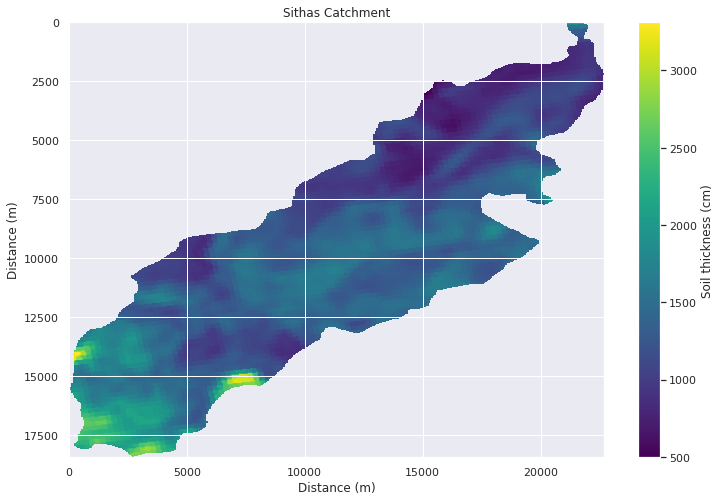

In [3]:
grdfile = '/work/armitagj/runs/caesar-explore/sithas/DEM/removed_pits/DEM_TICKNESS_SOIL09-2020_CUT_SITHAS_RESAMPLE_WARP50.tif'
rio_array = rio.open(grdfile)
pix = rio_array.transform[0]
data_array = rio_array.read(1).astype(float) 
data_array[data_array <= 0] = np.nan
extent = [0, np.shape(data_array)[0] * pix, np.shape(data_array)[1] * pix, 0]
plt.figure()
plt.imshow(data_array, aspect='auto', cmap='viridis', extent=extent)
plt.colorbar(label='Soil thickness (cm)')
plt.title('Sithas Catchment')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.show()

There is a long history of meteorological measurements in the region, with the nearest station, Chalkio, having an uninterrupted 50 year record of precipitation.

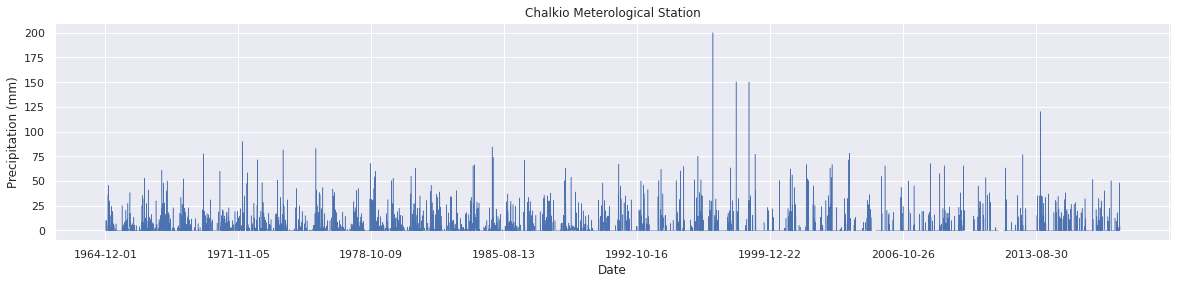

In [4]:
file = '/work/armitagj/runs/caesar-explore/sithas/input_data/Chalkio_station.txt'
chalkio = pd.read_csv(file, sep=' |,', index_col=False, comment='#', engine='python')
chalkio = chalkio.set_index('date')
sns.set(rc={'figure.figsize':(20, 4)})
plt.figure()
ax = chalkio['rainfall'].plot(linewidth=0.5)
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Date')
plt.title('Chalkio Meterological Station')
plt.show()

## HC with no depth to bedrock

The first model run is HC with no depth to bedrock. This means that there is always transportable sediment. It is assumed that there are three characteristic grains: an aggregation of silt and clay that is treated as suspended load, sand, and gravel. The proportions of this material are 86%, 13% and 1%, with characteristic grain sizes of 30 $\mu$m, 400 $\mu$m, and 4 mm. The settling velocity for the suspended load is 0.033 ms$^{-1}$.

The model is run for 4942 days, with the precipitation record starting from the year 1964. This length of model is chosen as it is the number of days reached after 120 hours of calculation on `ENER440` (I am limited to one compute node, 36 cpus, as the code is parrelised using OpenMP). 

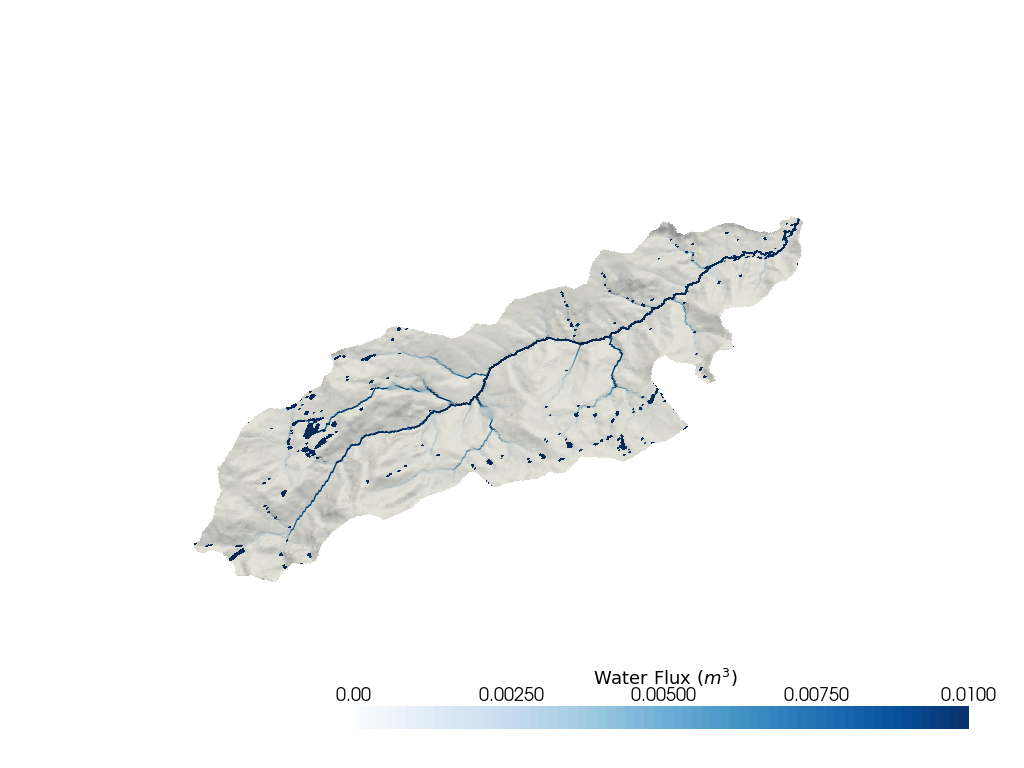

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [7]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/WaterDepths7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
water = pv.StructuredGrid(x, y, np.fliplr(data_array))
d = np.zeros_like(water.points)
d[:, 1] = water.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1], cmap='Blues', clim=[0,.01])
p.camera_position = cpos
p.add_scalar_bar(title='Water Flux ($m^3$)')
p.show(screenshot='caesar.png')

The model output after 4942 days shows that the initial DEM contains pits within which lakes form. This poses a problem: how to deal with these pits. The DEM could be treated to *pop* pits and create a surface over which water does not collect. In reality this region is karstic and infiltration and groundwater pathways will exist. 

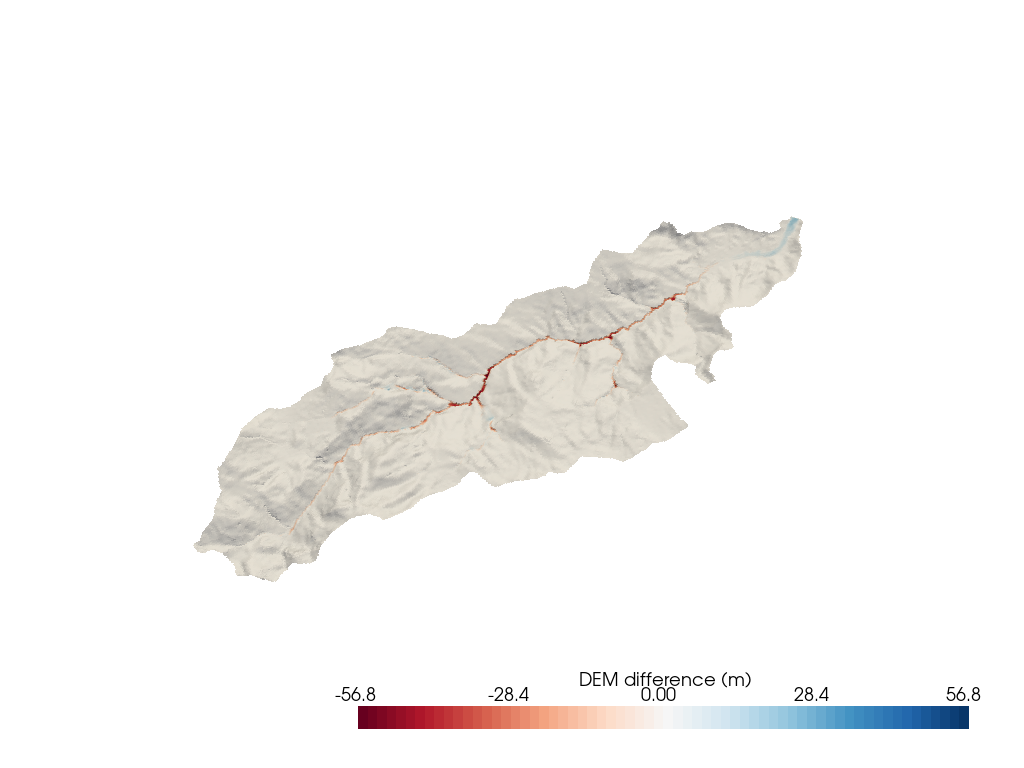

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [8]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/Elevations0.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
z0 = pv.StructuredGrid(x, y, np.fliplr(data_array))
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))
p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1] - d0[:,1], cmap='RdBu', clim=[-clim, clim])
p.camera_position = cpos
p.add_scalar_bar(title='DEM difference (m)')
p.show(screenshot='caesar.png')

Without a bedrock surface the HC model simulates up to 60 m of incision within the *4945* day duration of the model run. **I think this is likely too much erosion** 

<Figure size 1080x1080 with 0 Axes>

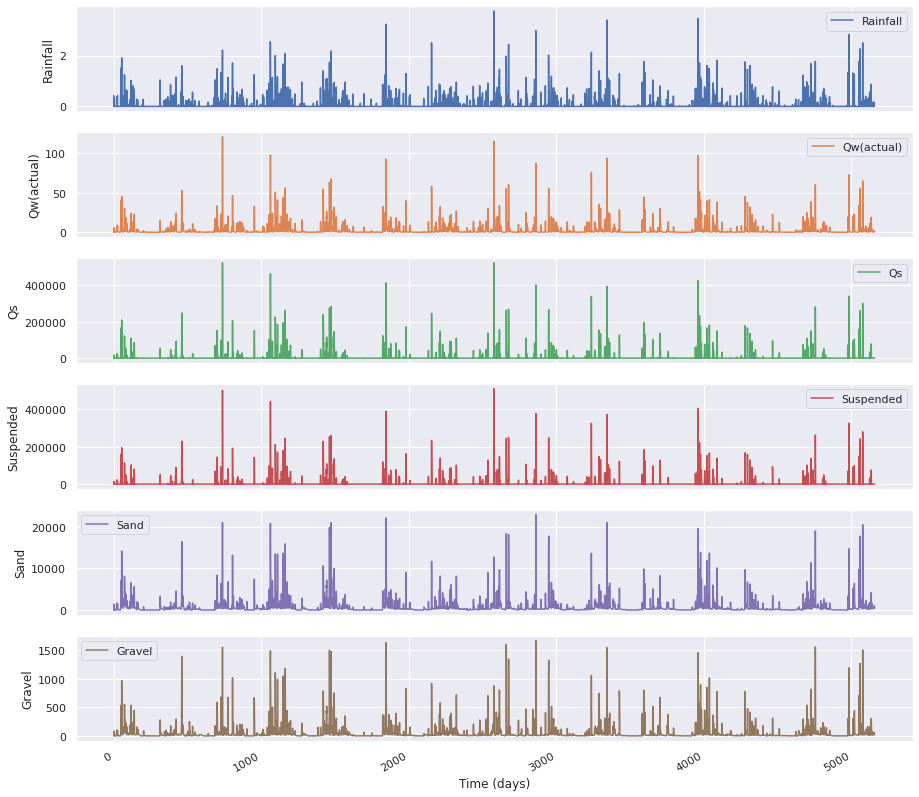

In [9]:
file = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/Sithas_v7.dat'
sithas_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
file = '/work/armitagj/runs/caesar-explore/ener440/sithas/input_data/Chalkio_rain.txt'
sithas_rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
sithas_all = pd.concat([sithas_, sithas_rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'Suspended', 'Sand', 'Gravel']
axes = sithas_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_plot[i])
    i += 1
plt.xlabel('Time (days)')
plt.savefig('sithas_tseries.png')
plt.show()

The time series plotted above shows that HC responds to each season of increased precipitation. The response is filtered by the transformation from rainfall to water flux. It is perhaps interesting to see if the relationship between rainfall and sediment yield is linear or non-linear:

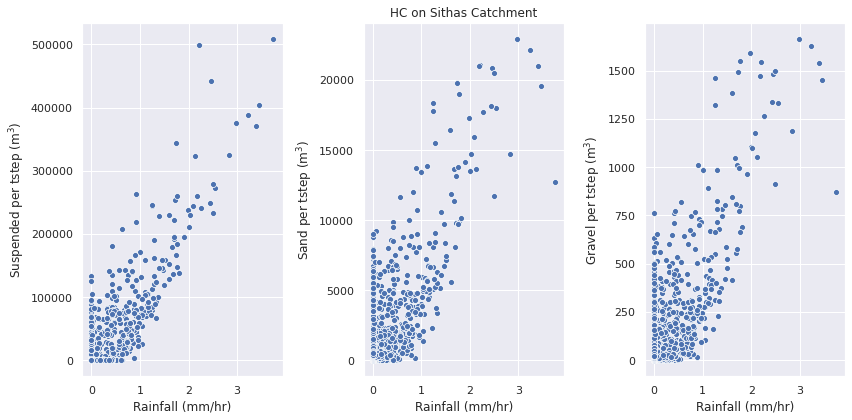

In [10]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(131)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Suspended'], ax=ax1)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax2 = plt.subplot(132)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Sand'], ax=ax2)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.title('HC on Sithas Catchment')
ax3 = plt.subplot(133)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Gravel'], ax=ax3)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.tight_layout()
plt.savefig('sithas.png')
plt.show()

The initial model run allows a first look at how HC simulates catchment response to precipitation change on a daily bases. Bedload sediment flux is expected to be proportional to the water flux raised to the power of 9/5 from the rules used within the model. Sediment flux is also a function of local topographic slope. The sediment output of the model domain responds linearly to change in precipitation. However there is some large variation in the response. This is due to the amount of water within the system prior to increased precipitation.

*At this point I want to know how observations of sediment yield vary with precipitation. This must be possible, but requires connecting two datasets that are typically collected by different agencies. I am in discussion with Jens Turowski (GFZ Potsdam) to locate a good catchment to get an idea of the observed correlation.*

Right now I would venture to say that to a first order the HC model would suggest that there is a linear relationship between sediment yield and precipitation. There is a significant variation within this relationship however, that would show that some storms would lead to significant sediment delivery to the Gulf of Corinth, and some that wont. It is possibly a bit premature however to read too much into this early model.

## fLEM with no bedrock (there is none in this model)

This model solves for the conservation of mass assuming there is a infinite supply of sediment,
$$\frac{\partial z}{\partial t} = - \nabla \cdot \mathbf{q}_{s} $$
and
$$ \mathbf{q}_{s} = \kappa \nabla z + c\mathbf{q}_{w}^{n} \cdot \nabla z $$
Water flux is calculated from the upstream length of flow directions and points down slope. There are three parameters that are assumed constant; $\kappa$, $c$, and $n$. These have no empirical observations, and are instead *tuned* to match some observed sediment flux or other landscape change. I chose $\kappa = 0.1$, $c = 10^{-5}$ and $n=1.5$.

fLEM was developed for long term landscape evolution modeling. It was therefore assumed that there is a mean annual precipitation rate input, and that this would not fall to zero. Therefore in this initial test run, there is always assumed to be a very small background precipitation of $10^{-6}$ m/yr. This is the equivalent to a uniform *wetness* to the surface of the model. **The impact of this assumption should be explored**.

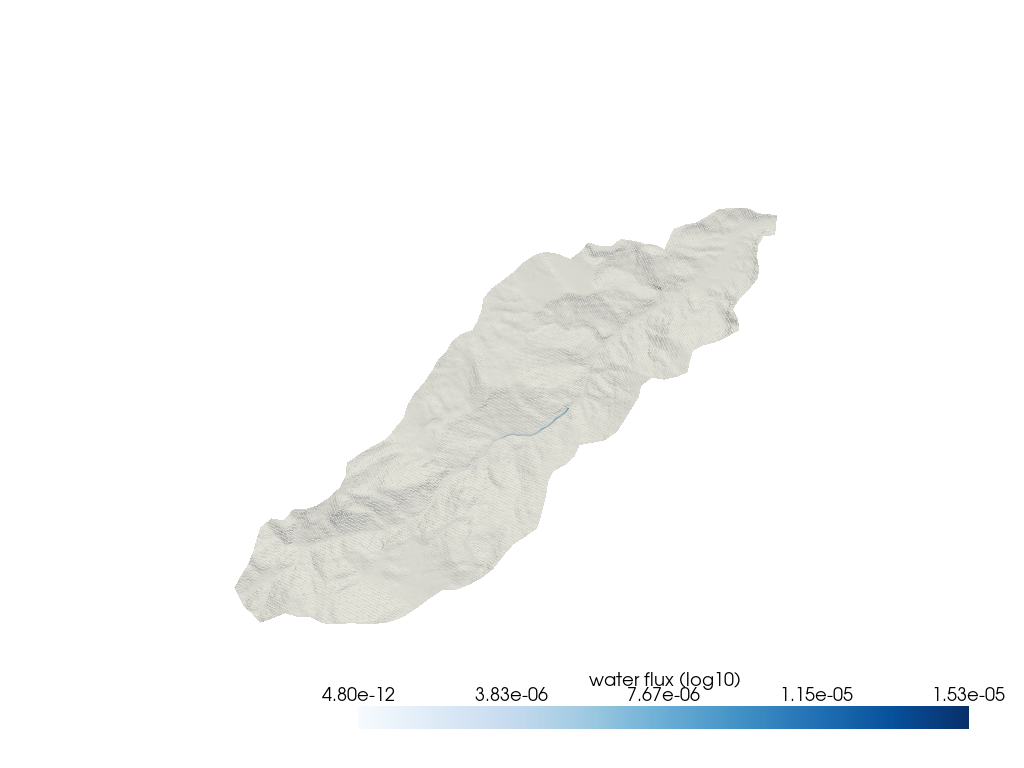

[(-0.5288363330028047, 0.2836891797655563, 2.489795094110841),
 (0.41742081951815635, 0.5049999998882413, 0.13443556556012481),
 (0.9281913292656436, -0.009836619274434136, 0.37197324795921455)]

In [12]:
elevation = pv.read('/work/armitagj/code/flem/tests/sithas/u_solution_512_999000000.vtu')
flux = pv.read('/work/armitagj/code/flem/tests/sithas/q_solution_512_999000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warp = flux.warp_by_scalar(scalars='elevation',factor=0.01)

cpos = [(-0.5288363330028047, 0.2836891797655563, 2.489795094110841),
        (0.41742081951815635, 0.5049999998882413, 0.13443556556012481),
        (0.9281913292656436, -0.009836619274434136, 0.37197324795921455)]

p = pv.Plotter(notebook=True, border=False)
#p.add_text("Riu Bergantes, Iberian Massif, Spain", font_size=12)
p.add_mesh(warp, scalars='water flux (log10)', cmap='Blues', lighting=True)
p.camera_position = cpos
p.show()

After 100 days it can be seen that water is not leaving the model domain, rather it is stuck within the catchment. This is because water only flows down topographic slope. It get stuck behind barriers until there is sufficient deposition to overcome that barrier. Over a short time scale and with the choice of $\kappa$ and $c$ these barriers have not been removed. In fact the difference in elevation is very small:

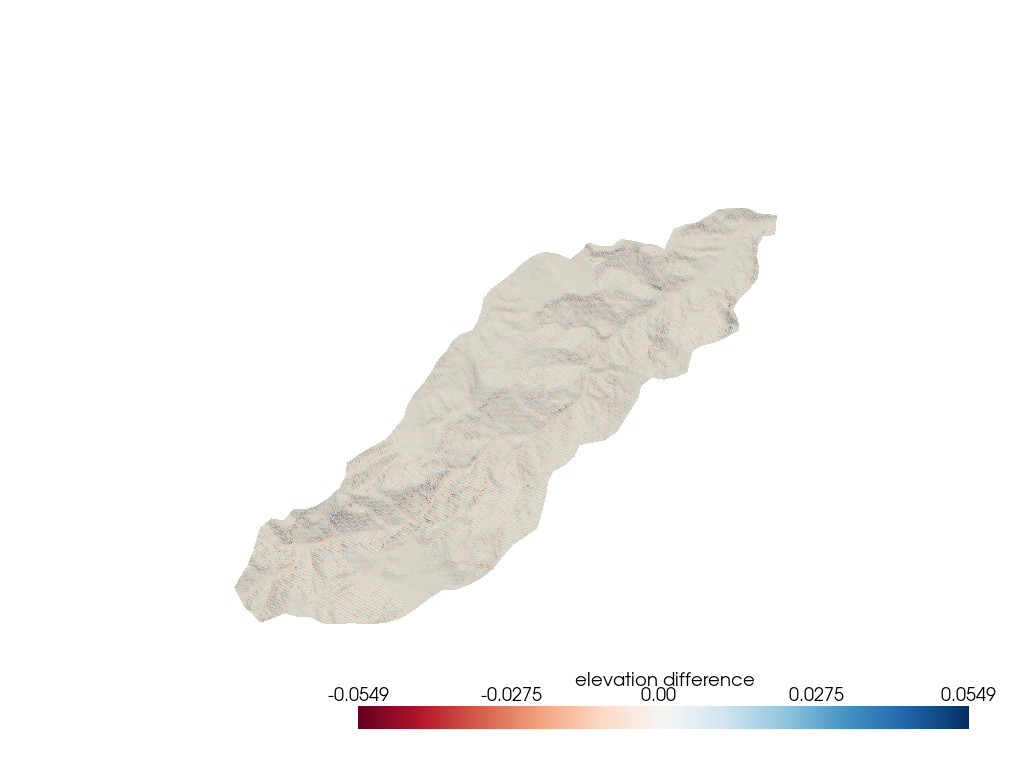

[(-0.5288363330028047, 0.2836891797655563, 2.489795094110841),
 (0.41742081951815635, 0.5049999998882413, 0.13443556556012481),
 (0.9281913292656436, -0.009836619274434136, 0.37197324795921455)]

In [13]:
elevation = pv.read('/work/armitagj/code/flem/tests/sithas/u_solution_512_1000000.vtu')
flux['start_elevation'] = elevation['elv']
flux['elevation difference'] = flux['elevation'] - flux['start_elevation']
warp = flux.warp_by_scalar(scalars='elevation',factor=0.01)

cpos = [(-0.5288363330028047, 0.2836891797655563, 2.489795094110841),
        (0.41742081951815635, 0.5049999998882413, 0.13443556556012481),
        (0.9281913292656436, -0.009836619274434136, 0.37197324795921455)]

clim = np.nanmax(np.abs(flux['elevation difference']))
p = pv.Plotter(notebook=True, border=False)
#p.add_text("Riu Bergantes, Iberian Massif, Spain", font_size=12)
p.add_mesh(warp, scalars='elevation difference', cmap='RdBu', clim=[-clim, clim], lighting=True)
p.camera_position = cpos
p.show()

It looks like a parameter space search would be the next obvious thing to do, to increase the rate of erosion and the transport of material.

<Figure size 864x576 with 0 Axes>

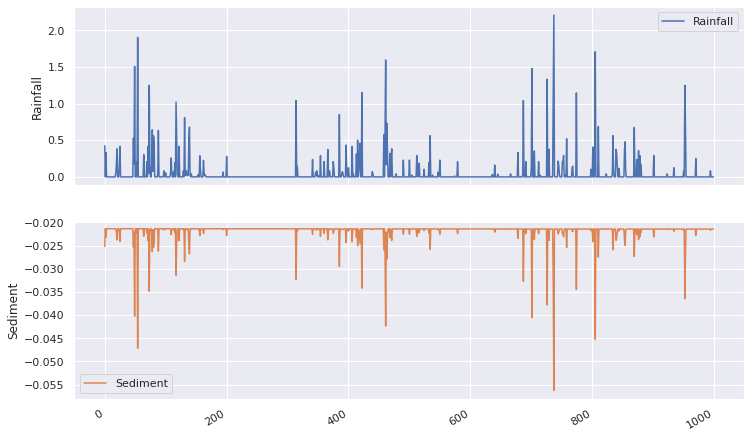

In [14]:
file = '/work/armitagj/code/flem/tests/sithas/sed_flux_sithas.txt'
sithas_sed = pd.read_csv(file, sep=',', index_col=False,
                       names=['Time', 'Sediment'])
file = '/work/armitagj/code/flem/tests/Chalkio_rain.txt'
sithas_rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
sithas_all = pd.concat([sithas_sed, sithas_rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(12, 8)})
plt.figure()
cols_plot = ['Rainfall', 'Sediment']
axes = sithas_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_plot[i])
    i += 1
plt.show()

Sediment flux is negative as there is net deposition, but it is still fun to see how rainfall and sediment flux are related. They should be related by a power law:

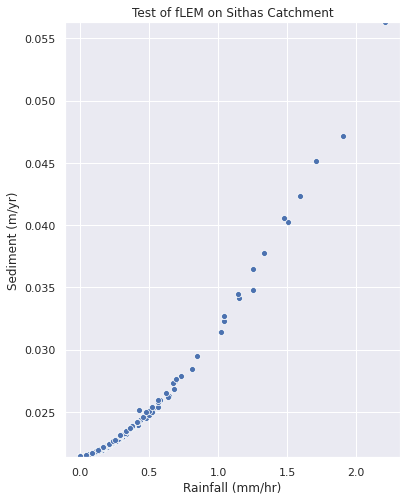

In [15]:
plt.figure(figsize=(6,8))
g = sns.scatterplot(sithas_all.Rainfall.iloc[0:-1], -sithas_all.Sediment.iloc[0:-1])
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' (m/yr)')
plt.ylim((np.min(-sithas_all['Sediment']), np.max(-sithas_all['Sediment'])))
plt.title('Test of fLEM on Sithas Catchment')
plt.show()

## HC with bedrock

Here we have an erodable surface and a bedrock below which can erode:

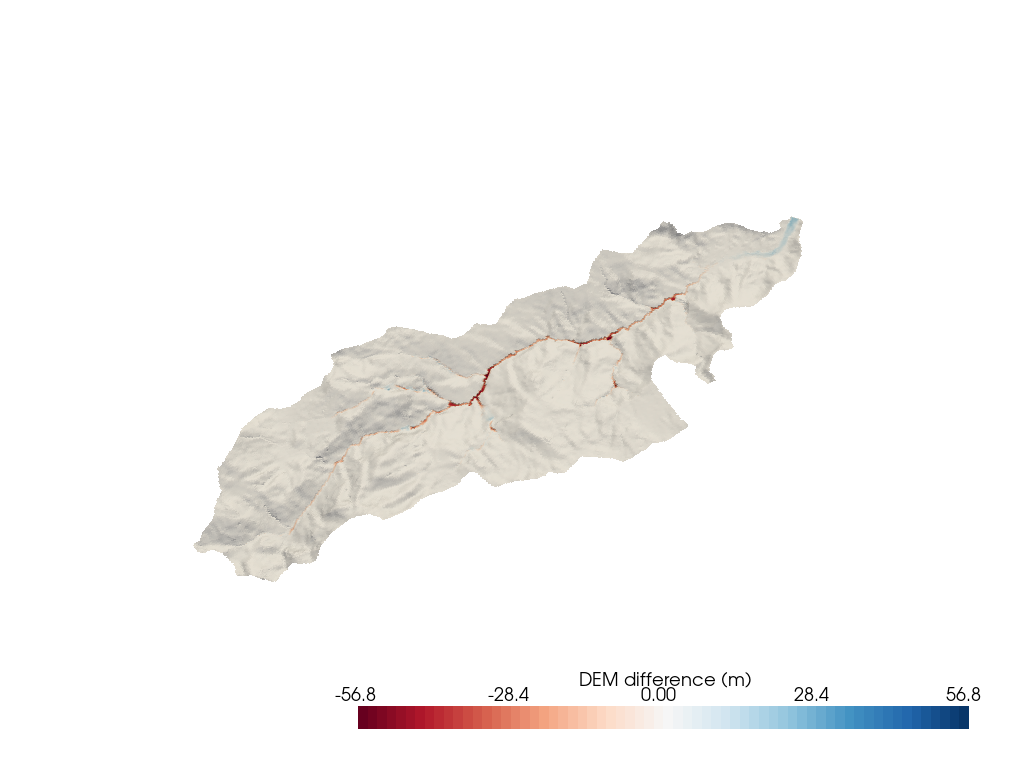

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [16]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_bedrock/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_bedrock/results/Elevations0.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
z0 = pv.StructuredGrid(x, y, np.fliplr(data_array))
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))
p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1] - d0[:,1], cmap='RdBu', clim=[-clim, clim])
p.camera_position = cpos
p.add_scalar_bar(title='DEM difference (m)')
p.show(screenshot='caesar.png')

There is still significant erosion within the central channel. This is likely because of the coarse nature of the input depth to bedrock taken from the soil thickness map. We likely need a more accurate thickness for transportable material, which could be taken from satellite images. This might be a major area for study to get more accurate simulations for the quantity of erosion and the change in sediment yield due to change in precipitation.

<Figure size 1080x1080 with 0 Axes>

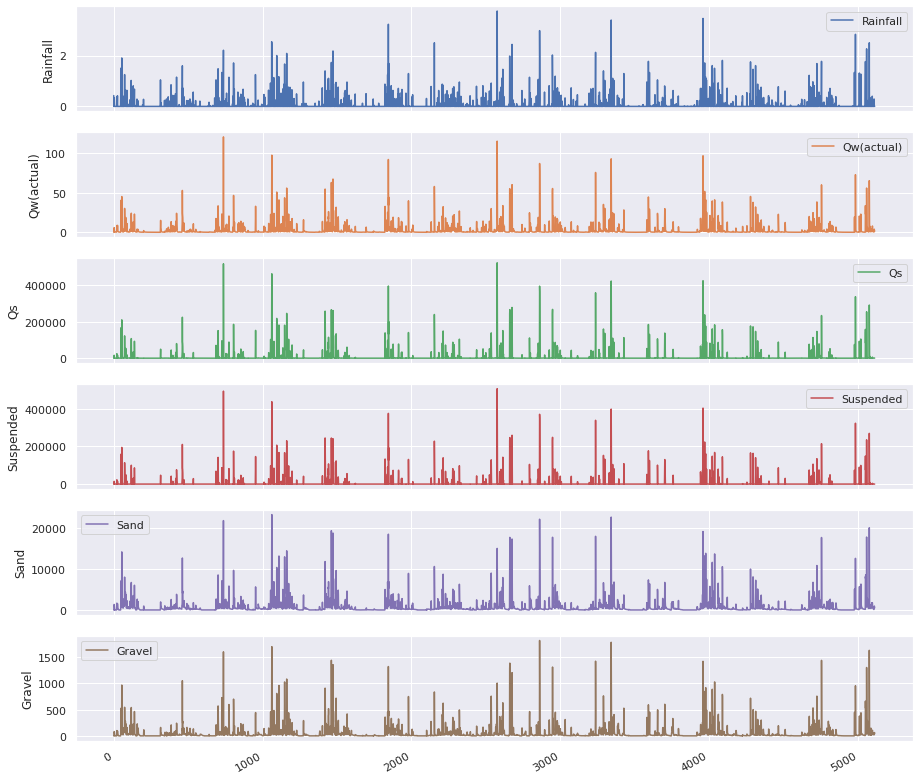

In [17]:
file = '/work/armitagj/runs/caesar-explore/ener440/sithas_bedrock/results/Sithas_v7.dat'
sithas_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
file = '/work/armitagj/runs/caesar-explore/ener440/sithas/input_data/Chalkio_rain.txt'
sithas_rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
sithas_all = pd.concat([sithas_, sithas_rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'Suspended', 'Sand', 'Gravel']
axes = sithas_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_plot[i])
    i += 1
plt.show()

The response to precipitation change is similar in magnitude to the model without bedrock, but again this could be due to the thickness of the transportable material within the model.

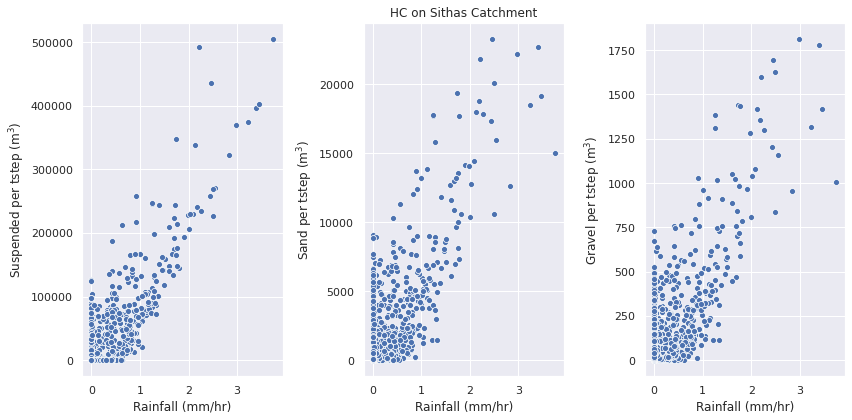

In [18]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(131)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Suspended'], ax=ax1)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax2 = plt.subplot(132)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Sand'], ax=ax2)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.title('HC on Sithas Catchment')
ax3 = plt.subplot(133)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Gravel'], ax=ax3)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.tight_layout()
plt.show()

The relationship between sediment yield and rainfall is very similar to the model without bedrock. Below I will explore the relationship a bit further.

## Relationship between precipitation and sediment yield

The model fLEM assumes that sediment flux scales with water flux raised to the power of $n$, which needs to be $> 1$ for concentrative flow. Water flux is taken to be linearly related to precipitation rate, and therefore the sediment flux scales with precipitation raised to the power of 1.5. The expectation of simple relationship between precipitation and sediment yield is reasonable if the period of averaging is large. That is the assumptions behind the model fLEM are reasonable for large time steps, those that are greater than an individual flood event. For large catchments, a flood could last days, and therefore the time step needs to be significantly larger than this. This makes the comparison between fLEM and HC difficult as I have violated that limit on time step size.

HC is however technically the appropriate model to capture events on the timescale of individual floods. Here the relationship between sediment yield and rainfall is more complex. At a broad level, and including the more extreme events, the relationship between yield and precipitation is potentially linear, but with a broad amount of scatter. This scatter might be reduced if we look at the time of observation. Using a rolling average and standard deviation, the relationship between sediment flux and time averaged precipitation can be explored. I chose a window of 3, 5 or 10 days:

In [19]:
windows = [3, 5, 10]
for window in windows:
    
    sithas_all['Rainfall Rolling Std. ' + str(window)] = sithas_all['Rainfall'].rolling(window).std().values
    sithas_all['Rainfall Rolling Mean. ' + str(window)] = sithas_all['Rainfall'].rolling(window).mean().values
    sithas_all['Rainfall Rolling Median. ' + str(window)] = sithas_all['Rainfall'].rolling(window).median().values
    
    sithas_all['Suspended Rolling Std. ' + str(window)] = sithas_all['Suspended'].rolling(window).std().values
    sithas_all['Suspended Rolling Mean. ' + str(window)] = sithas_all['Suspended'].rolling(window).mean().values
    sithas_all['Suspended Rolling Median. ' + str(window)] = sithas_all['Suspended'].rolling(window).median().values
    
    sithas_all['Sand Rolling Std. ' + str(window)] = sithas_all['Sand'].rolling(window).std().values
    sithas_all['Sand Rolling Mean. ' + str(window)] = sithas_all['Sand'].rolling(window).mean().values
    sithas_all['Sand Rolling Median. ' + str(window)] = sithas_all['Sand'].rolling(window).median().values
    
    sithas_all['Gravel Rolling Std. ' + str(window)] = sithas_all['Gravel'].rolling(window).std().values
    sithas_all['Gravel Rolling Mean. ' + str(window)] = sithas_all['Gravel'].rolling(window).mean().values
    sithas_all['Gravel Rolling Median. ' + str(window)] = sithas_all['Gravel'].rolling(window).median().values

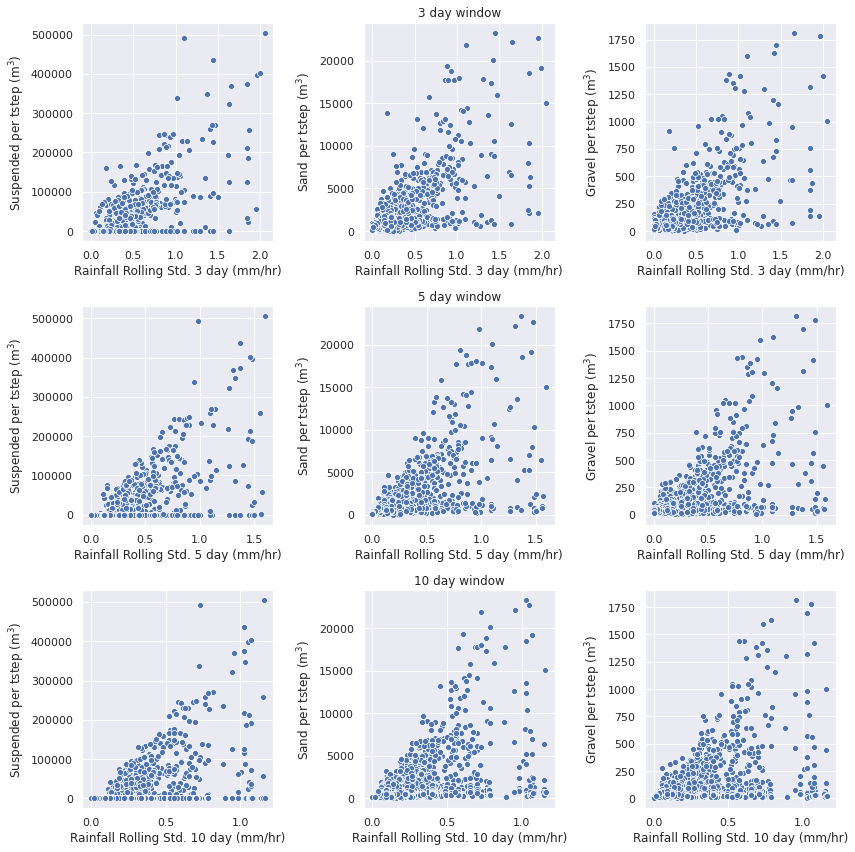

In [20]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Std. ' + str(window)], sithas_all['Suspended'], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Std. ' + str(window)], sithas_all['Sand'], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Std. ' + str(window)], sithas_all['Gravel'], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
    
plt.tight_layout()
plt.show()

Above I plot the relationship between the sediment output of suspended load, sand and gravel (bedload) against the standard deviation (Std.) of the 3, 5, and 10 day rolling window. It can be seen that the maximum amount of sediment per rainfall window follows a linear trend when compared to the variance (standard deviation) in the time window. The trend is relatively insensitive to the time window. However, the range of sediment output is insensitive to the variance. That is for high variance within the time window a large output of sediment is as likely as a low output.

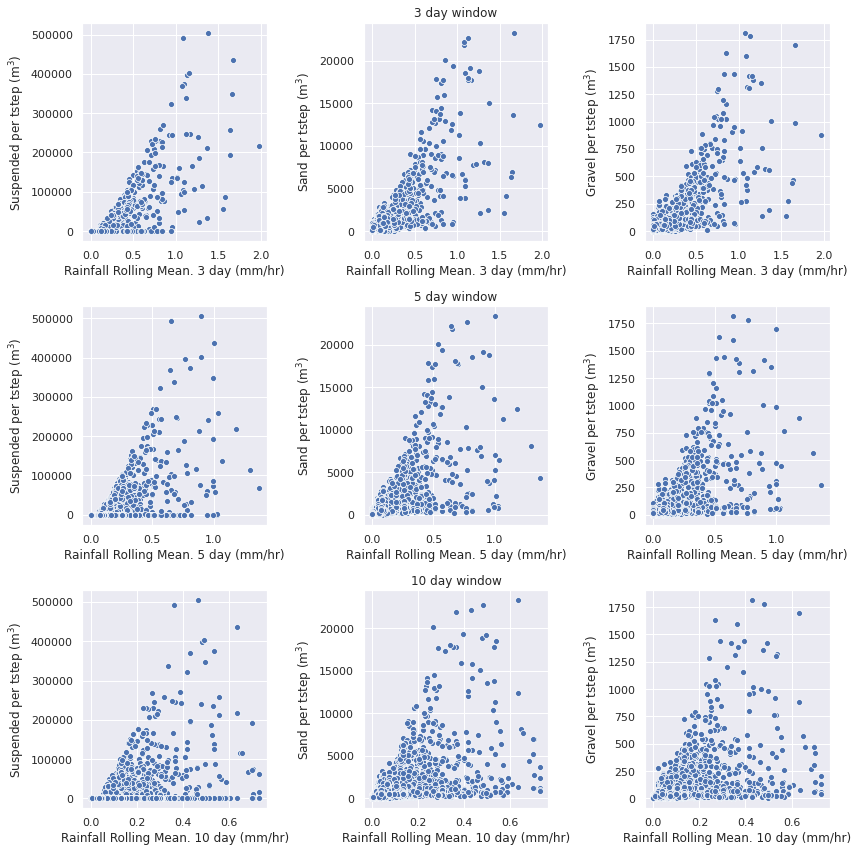

In [21]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)], sithas_all['Suspended'], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)], sithas_all['Sand'], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)], sithas_all['Gravel'], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
    
plt.tight_layout()
plt.show()

Above is the trend for the rolling mean of the precipitation for sediment output. For the three day rolling mean It would look like the sediment yield is most sensitive to the most recent precipitation days, as for the 3 day rolling mean the data follows some trend, all be it with a wide scatter. This scatter is less than for the relationship between the daily precipitation and sediment output however. Currently all days are equally weighted, lets look at a Gaussian weighting function:

In [22]:
windows = [3, 5, 10]
for window in windows:
    
    sithas_all['Rainfall Gaussian Std. ' + str(window)] = sithas_all['Rainfall'].rolling(window, win_type='gaussian').std(std=3).values
    sithas_all['Rainfall Gaussian Mean. ' + str(window)] = sithas_all['Rainfall'].rolling(window, win_type='gaussian').mean(std=3).values
    
    sithas_all['Suspended Gaussian Std. ' + str(window)] = sithas_all['Suspended'].rolling(window, win_type='gaussian').std(std=3).values
    sithas_all['Suspended Gaussian Mean. ' + str(window)] = sithas_all['Suspended'].rolling(window, win_type='gaussian').mean(std=3).values
 
    sithas_all['Sand Gaussian Std. ' + str(window)] = sithas_all['Sand'].rolling(window, win_type='gaussian').std(std=3).values
    sithas_all['Sand Gaussian Mean. ' + str(window)] = sithas_all['Sand'].rolling(window, win_type='gaussian').mean(std=3).values
    
    sithas_all['Gravel Gaussian Std. ' + str(window)] = sithas_all['Gravel'].rolling(window, win_type='gaussian').std(std=3).values
    sithas_all['Gravel Gaussian Mean. ' + str(window)] = sithas_all['Gravel'].rolling(window, win_type='gaussian').mean(std=3).values

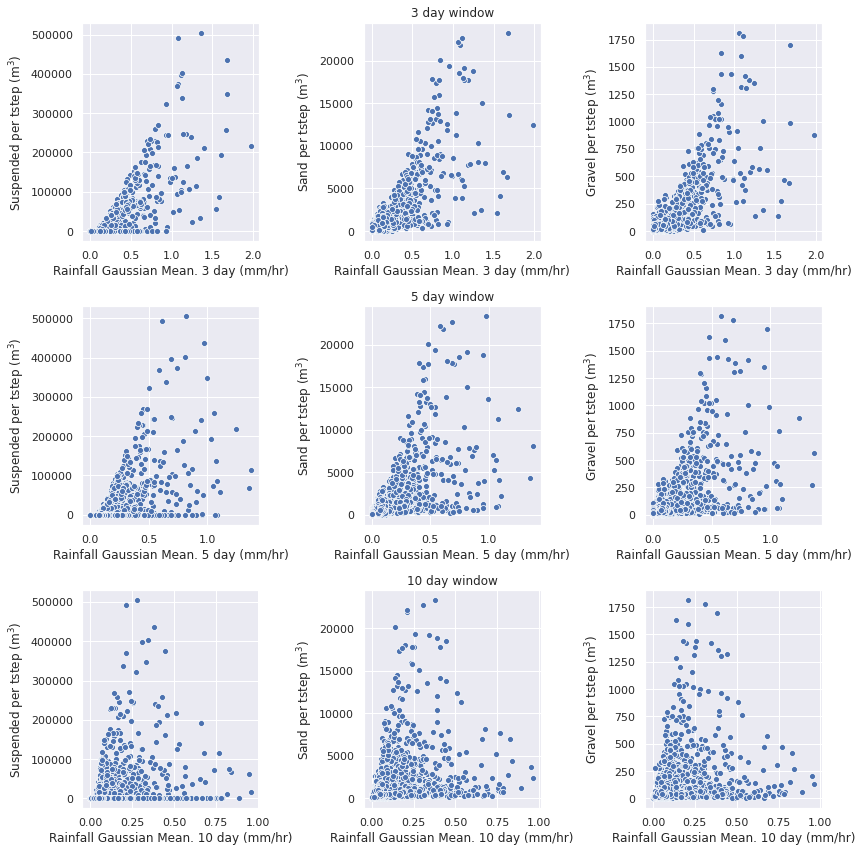

In [23]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Gaussian Mean. ' + str(window)], sithas_all['Suspended'], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Gaussian Mean. ' + str(window)], sithas_all['Sand'], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Gaussian Mean. ' + str(window)], sithas_all['Gravel'], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
    
plt.tight_layout()
plt.show()

I don't see a vast improvement, but a Gaussian weighting over 3 days probably does not change much in any case.

It is then interesting to see of the time averaging of the observation of sediment yield has an impact on the relationship between sediment flux. Bellow I assume that the observations are averaged of the same three time windows: 

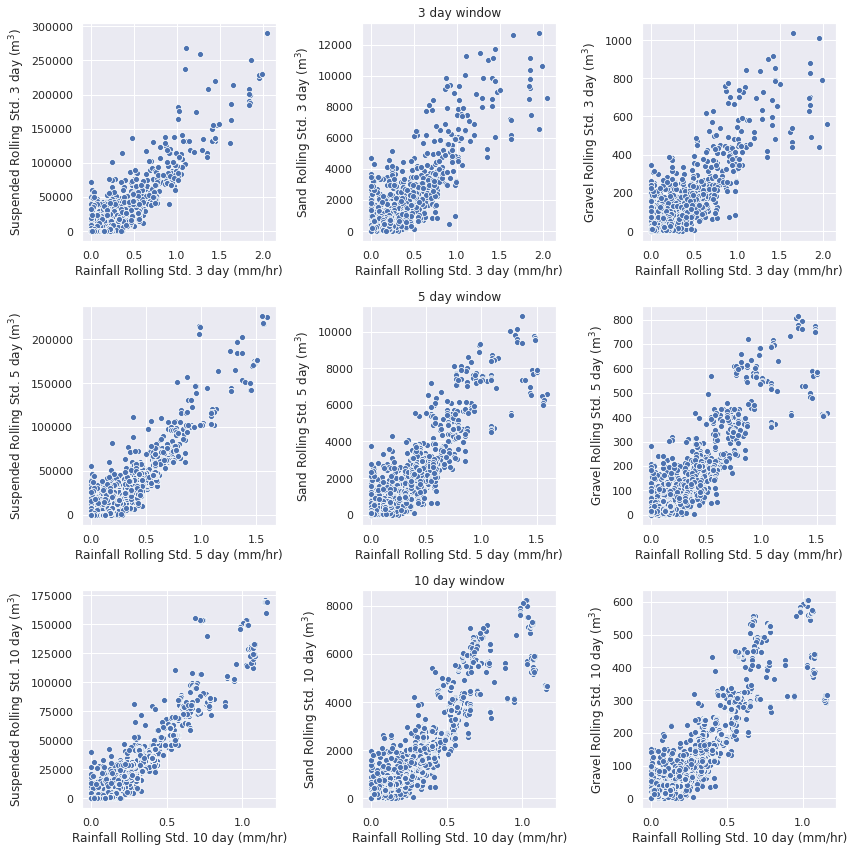

In [24]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Std. ' + str(window)],
                        sithas_all['Suspended Rolling Std. ' + str(window)], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Std. ' + str(window)],
                        sithas_all['Sand Rolling Std. ' + str(window)], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Std. ' + str(window)],
                        sithas_all['Gravel Rolling Std. ' + str(window)], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    
plt.tight_layout()
plt.show()

The standard deviations look correlated.

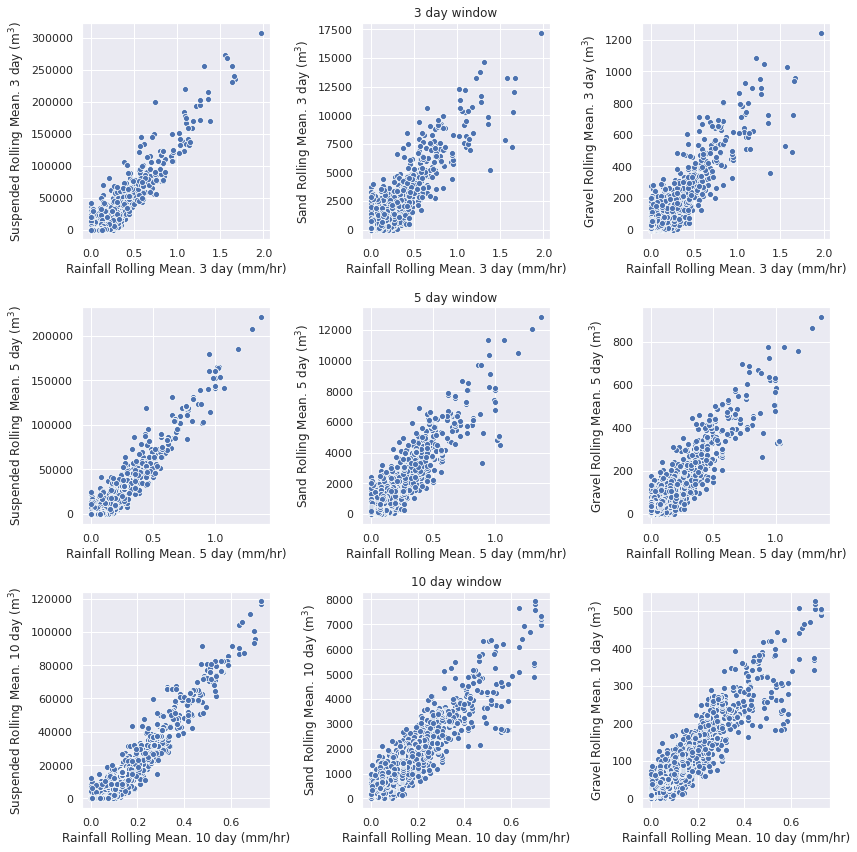

In [25]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Suspended Rolling Mean. ' + str(window)], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Sand Rolling Mean. ' + str(window)], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Gravel Rolling Mean. ' + str(window)], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    
plt.tight_layout()
plt.show()

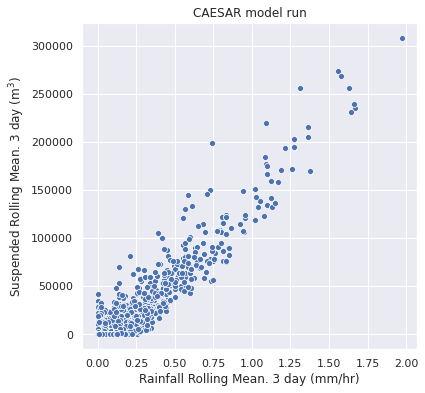

In [26]:
plt.figure(figsize=[6, 6])

window = windows[0]

g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                    sithas_all['Suspended Rolling Mean. ' + str(window)])
g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
plt.title('CAESAR model run')
plt.savefig('Sithas_5000days')
plt.show()

Here it is clear that as the time window for the rolling mean is increased the model recovers a near linear relationship between precipitation and sediment yield. **This is quite a nice result** and is in line with the expectation that as the time window of observation is increased we can use simpler models, such as fLEM. 

## A brief look at observations of sediment yield and precipitation

Unfortunately we do not have a sediment trap in the Sithas catchment. Christine Franke (MINES) and Claire Alary (Univ. Lille) have however been running a project measuring sediment yield from a small catchment in Northern France [(Patault et al., 2019)](https://doi.org/10.1016/j.heliyon.2019.e01407). This data covers two winters, from 2016 to 2018.  

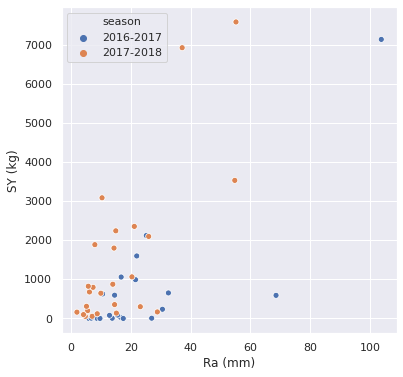

In [27]:
file = '~/Documents/MPH03001-benchmark/data/Pommeroye_catchement_2016_2017.csv'
df = pd.read_csv(file)
strings = df.Date
date = []
for string in strings:
    date.append(datetime.datetime.strptime(string, '%d/%m/%y'))
df['Date (ISO)'] = date
season = []
for day in date:
    if day > datetime.datetime.strptime('2017-07-01', '%Y-%m-%d'):
        season.append('2017-2018')
    else:
        season.append('2016-2017')
df['season'] = season
plt.figure(figsize=[6, 6])
g = sns.scatterplot(x='Ra (mm)', y='SY (kg)', hue='season', data=df)
plt.show()

From this small data set it can be seen that there is considerable scatter. Just for fun, lets see if a time averaging will reduce the scatter.

In [28]:
wdf = df.set_index('Date (ISO)')
windows = [5, 10, 20] 
for window in windows:
    
    wdf['Rainfall Rolling Std. ' + str(window)] = wdf['Ra (mm)'].rolling(str(window * 60*60*24) + 's').std().values
    wdf['Rainfall Rolling Mean ' + str(window)] = wdf['Ra (mm)'].rolling(str(window * 60*60*24) + 's').mean().values
    
    wdf['Sediment Yield Rolling Std. ' + str(window)] = wdf['SY (kg)'].rolling(str(window * 60*60*24) + 's').std().values
    wdf['Sediment Yield Rolling Mean ' + str(window)] = wdf['SY (kg)'].rolling(str(window * 60*60*24) + 's').mean().values

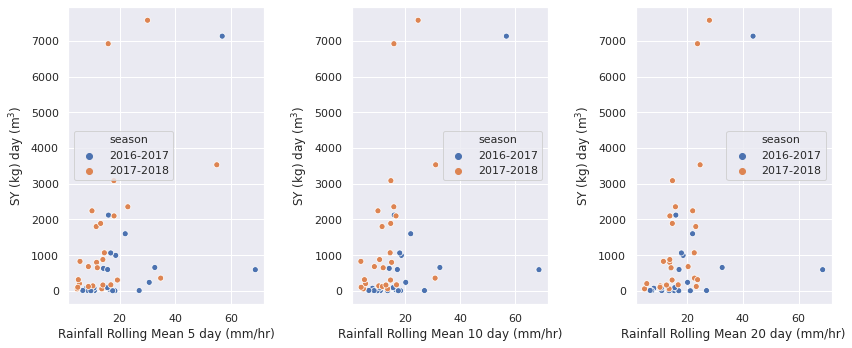

In [29]:
plt.figure(figsize=(12,5))

nplot = 130
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    g = sns.scatterplot(wdf['Rainfall Rolling Mean ' + str(window)],
                        wdf['SY (kg)'], hue=wdf['season'], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    
plt.tight_layout()
plt.show()

Above is sediment yield plotted against the rolling mean of precipitation.

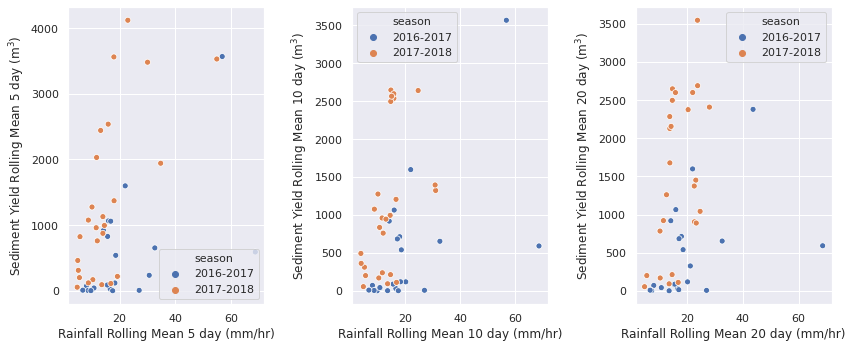

In [30]:
plt.figure(figsize=(12,5))

nplot = 130
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    g = sns.scatterplot(wdf['Rainfall Rolling Mean ' + str(window)],
                        wdf['Sediment Yield Rolling Mean ' + str(window)], hue=wdf['season'], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    
plt.tight_layout()
plt.show()


The time averaging does not make much of a difference in the real world.

## Avenues for future research

* The model HC is eroding to heavily in the main channel. This can be reduced by have a better describtion of the *depth to bedrock*. Currently we are using a large scale dataset, where the thickness of mobile soil cover is up to 20 m in the channel. This is not the case. It would be interesting to launch a study into how the depth to bedrock can be better mapped. One avenue would be to explore how satalite imagery and classification algorithms can be used to improve the map. This could also be combined with field trips to ground truth the remote sensing method.

* Water does not leave the catchment for fLEM. Under the assumption that hydraulic gradient is the equivalent to the topographic gradient small bariers tot he flow cannot be overcome. This is a very big limitation. One solution would be to include some *backwater* calculations (see [sedFlow](https://esurf.copernicus.org/articles/3/15/2015/)), to allow lakes to form and then the water to spill out (as done in DionisosFlow). This will vastly improve the model.

* Both models predict interesting relationships between rainfall and sediment yield. The transport laws in HC could do with further exploratory investigation. Furthermore it would be interesting to see how much DionisosFlow deviates from the simple fLEM model. To do this would require testing how ArcaDES would handle an irregular mesh.

* For short sampling times, or averaging windows, the sediment yeild is not linearly related to rainfall. A collaboration with Christine Franke (MINES) and Claire Alary (Univ. Lille) could be explored as they will be enlarging their study of the Pommeroye catchment in Northern France. Early discussions would suggest that there is a strong interest in this, as they do not currently have a strong modelling experties within the research project (and we lack the data).

* Overall I think there are a lot of avenues and hope to elaborate on this is 2021.